In [1]:
from qiskit.quantum_info import Operator
from qiskit.aqua.operators import WeightedPauliOperator,  X, Z, I

## <center>  $H=\begin{pmatrix}−0.2524859 &  0.18121 \\ 0.18121 &−1.8318639  \end{pmatrix}= \\-1.0421749I+ 0.789689Z+ 0.181210X. $ <center> 

In [2]:
pauli_dict = {
    'paulis': [{"coeff": {"imag": 0.0, "real": -1.0421749}, "label": "I"},
              {"coeff": {"imag": 0.0, "real": 0.789689}, "label": "Z"},
              {"coeff": {"imag": 0.0, "real": 0.181210}, "label": "X"}
              ]
}
qubit_op = WeightedPauliOperator.from_dict(pauli_dict)

In [3]:
print(qubit_op.print_details())

I	(-1.0421749+0j)
Z	(0.789689+0j)
X	(0.18121+0j)



In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.circuit import ParameterVector
from qiskit.tools.visualization import circuit_drawer
from math import pi

In [5]:
def ansatz(theta):
    test=QuantumCircuit(1)
    test.ry(theta,0)
    return test

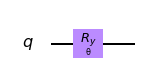

In [6]:
from qiskit.circuit import Parameter
theta = Parameter('θ')
var_circ=ansatz(theta)
var_circ.draw(output='mpl',plot_barriers=0)

In [7]:
from qiskit.aqua import QuantumInstance
from qiskit.aqua.algorithms import VQE, NumPyMinimumEigensolver ,ExactEigensolver
from qiskit.aqua.components.optimizers import COBYLA
from qiskit import Aer

In [8]:
optimizer = COBYLA(maxiter=100)
backend = Aer.get_backend('statevector_simulator')
vqe = VQE(operator=qubit_op, optimizer=optimizer, quantum_instance=backend)

In [9]:
vqe.var_form = var_circ
result = vqe.compute_minimum_eigenvalue()
print('VQE:', result.eigenvalue.real)

VQE: -1.8523883136876


### Solution

In [10]:
shot=10000
simulator = Aer.get_backend('qasm_simulator')
import math

def M(x0):
    theta=x0[0]
    M=-1.0421749
    ####caculate the expectation value of 0.789689𝑍
    qr = QuantumRegister(1) # initiate the circuit
    cr = ClassicalRegister(1) #
    Cix= QuantumCircuit(qr, cr) #
    #Cix.x(0) initial in |1>
    Cix.ry(theta,0) #the ansatz 
    Cix.measure(0,0)       
    job = execute(Cix, simulator, shots=shot) 
    result = job.result().get_counts()#collect the data
    
    P_0=result.get('0',0)/shot
    P_1=result.get('1',0)/shot
    temp=P_0-P_1  
    #temp is the expectation value of Z
    M+=temp*0.789689
    
    ####caculate the expectation value of 0.181210𝑋
    qr = QuantumRegister(1)
    cr = ClassicalRegister(1)
    Cix= QuantumCircuit(qr, cr)
    #Cix.x(0)  initial in |1>
    Cix.ry(theta,0)# the ansatz
    Cix.ry(-math.pi/2,0)# rotate the measurement frame
    Cix.measure(0,0)       
    job = execute(Cix, simulator, shots=shot) 
    result = job.result().get_counts()
        
    P_0=result.get('0',0)/shot
    P_1=result.get('1',0)/shot
    temp=P_0-P_1 
    #temp is the expectation value of X    
    M+=temp*0.181210
    return M

In [11]:
from scipy.optimize import minimize
initial_guess=[0]

ans=minimize(M,initial_guess,method='COBYLA')
ans

     fun: -1.8511889852
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 22
  status: 1
 success: True
       x: array([3.328225])